# Набір даних

> **ЗАДАЧА**: [Набір даних про дощі в Австралії](https://kaggle.com/jsphyg/weather-dataset-rattle-package) містить приблизно 10 років щоденних спостережень за погодою з численних австралійських метеостанцій. Ось невеликий зразок з набору даних:
>
> ![](https://i.imgur.com/5QNJvir.png)
>
> Як науковець з даних у Бюро метеорології, вам доручено створити повністю автоматизовану систему, яка може використовувати дані про погоду на сьогодні для певного місця, щоб передбачити, чи буде дощ у цьому місці завтра.
>
>
> ![](https://i.imgur.com/KWfcpcO.png)

У попередніх експериментах наш найбільший скор був досягнутий з `DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)` і він був наступним (`model.score` - тобто accuracy)


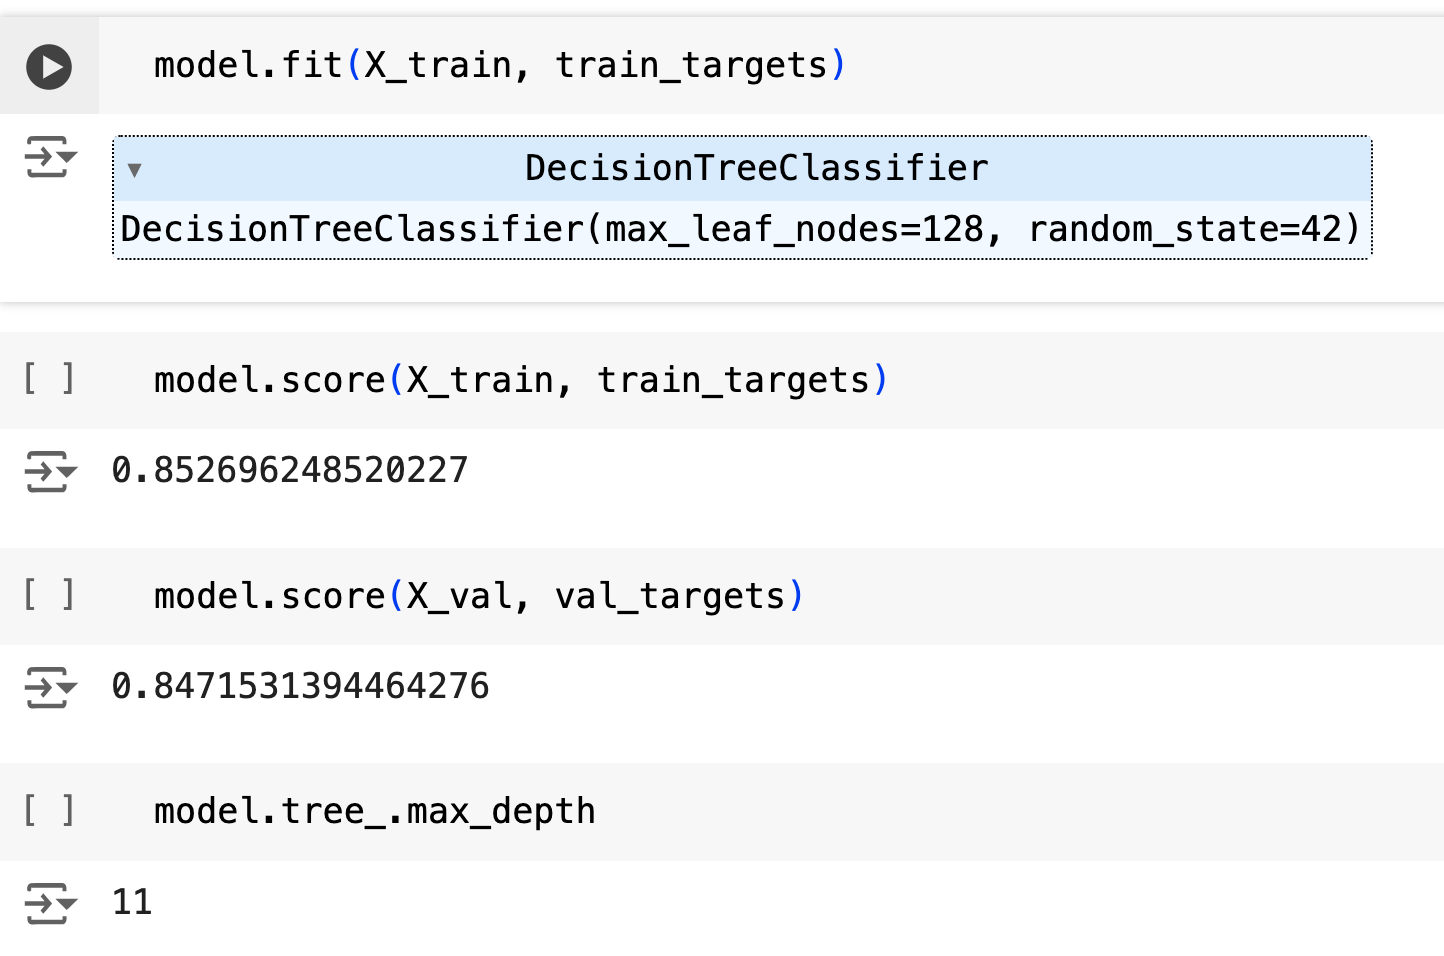

Поглянемо, чи дозволять нам алгоритми бустингу досягнути кращих результатів.

In [4]:
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# Завантаження даних
Завантажуємо дані з нашим розробленим раніше препроцесингом, в тому числі категоріальних змінних, що потрібно для алгоритмів AdaBoost та GradientBoosting.

In [2]:
%load_ext autoreload
%autoreload 2

from weather_data_processing import preprocess_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
raw_df = pd.read_csv('../../../data/weather-dataset-rattle-package/weatherAUS.csv')
data = preprocess_data(raw_df)

In [7]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']
X_test = data['test_X']
test_targets = data['test_y']

In [8]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.516509,0.517241,0.001617,0.064199,0.532098,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490075,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.375000,0.559387,0.000000,0.064199,0.532098,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478106,0.490075,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.504717,0.570881,0.000000,0.064199,0.532098,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478106,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.417453,0.614943,0.000000,0.064199,0.532098,0.139535,0.126437,0.103448,0.45,0.16,0.613223,0.557756,0.478106,0.490075,0.520607,0.617188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
X_train.shape

(97988, 118)

# AdaBoost

Гіперпараметри алгоритму:

- `base_estimators`: вказує оцінювач базового типу, тобто алгоритм, який буде використовуватися як слабкий учень. За замовчуванням = `DecisionTreeClassifier(max_depth = 1)` - decision stump (пень).  
- `n_estimators`: максимальна кількість оцінювачів, при якій бустинг припиняється. За замовчуванням = 50  
- `learning_rate`: швидкість навчання зменшує внесок кожного класифікатора на `learning_rate`. Існує компроміс між `learning_rate` і `n_estimators`. За замовчуванням = 1.  
- `random_state`: робить висновок моделі відтворюваним. За замовчуванням = None  
- `loss`: тільки для регресора. Функція втрат використовується при оновленні ваг після кожної ітерації бустингу. `{‘linear’, ‘square’, ‘exponential’}`, за замовчуванням = `’linear’ `

In [9]:
from sklearn.ensemble import AdaBoostClassifier

In [10]:
RANDOM_STATE = 42

In [11]:
ada_clf = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=RANDOM_STATE)
model = ada_clf.fit(X_train, train_targets)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [12]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

In [ ]:
print(classification_report(train_targets, train_pred, digits=4))

              precision    recall  f1-score   support

          No     0.8703    0.9448    0.9060     76190
         Yes     0.7246    0.5079    0.5972     21798

    accuracy                         0.8476     97988
   macro avg     0.7974    0.7263    0.7516     97988
weighted avg     0.8379    0.8476    0.8373     97988



In [ ]:
print(classification_report(val_targets, val_pred, digits=4))

              precision    recall  f1-score   support

          No     0.8664    0.9577    0.9098     13511
         Yes     0.7346    0.4424    0.5522      3578

    accuracy                         0.8498     17089
   macro avg     0.8005    0.7000    0.7310     17089
weighted avg     0.8388    0.8498    0.8349     17089



In [ ]:
ada_clf.feature_importances_

array([0.02, 0.  , 0.08, 0.  , 0.1 , 0.08, 0.  , 0.02, 0.  , 0.22, 0.02,
       0.1 , 0.  , 0.04, 0.02, 0.02, 0.02, 0.  , 0.  , 0.  , 0.  , 0.02,
       0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.02, 0.02, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

По-перше, модель трохи краща на валідації. Також бачимо, що класифікатор AdaBoost дозволив виявити деякі ознаки як зовсім не важливі.

Можемо спробувати використовувати інші базові алгоритми (base learners). Спробуємо складніші, але менше моделей в ансамблі.

In [13]:
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=25,
    learning_rate=0.1,
    random_state=RANDOM_STATE)
ada_clf.fit(X_train, train_targets)

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

          No     0.8703    0.9448    0.9060     76190
         Yes     0.7246    0.5079    0.5972     21798

    accuracy                         0.8476     97988
   macro avg     0.7974    0.7263    0.7516     97988
weighted avg     0.8379    0.8476    0.8373     97988

              precision    recall  f1-score   support

          No     0.8664    0.9577    0.9098     13511
         Yes     0.7346    0.4424    0.5522      3578

    accuracy                         0.8498     17089
   macro avg     0.8005    0.7000    0.7310     17089
weighted avg     0.8388    0.8498    0.8349     17089



Тож, в Adaboost можемо використовувати різні базові моделі і експериментувати з їх кількістю

# Градієнтний бустинг
Замість оновлення ваг навчальних екземплярів, як в AdaBoost, Градієнтний бустинг підганяє нову модель до залишкових помилок.

### Гіперпараметри:

- `loss`: {‘log_loss’, ‘exponential’}, за замовчуванням = `log_loss`  
  Функція втрат для оптимізації. `log_loss` відноситься до біноміальної та мультіноміальної відхилень, тієї ж, що використовується в логістичній регресії. Це хороший вибір для класифікації з ймовірнісними вихідними даними. Для втрати `exponential` градієнтний бустинг відновлює алгоритм AdaBoost.

- `learning_rate`: `float`, за замовчуванням = `0.1`  
  `Learning rate` зменшує внесок кожного дерева на `learning_rate`. Існує компроміс між `learning_rate` та `n_estimators`. Значення повинні бути в діапазоні [0.0, inf).

- `n_estimators`: `int`, за замовчуванням = `100`  
  Кількість виконуваних етапів бустингу. Градієнтний бустинг досить стійкий до перенавчання, тому велика кількість зазвичай призводить до кращої продуктивності. Значення повинні бути в діапазоні [1, inf).

- `subsample`: `float`, за замовчуванням = `1.0`  
  Частка вибірки, яка буде використовуватися для підбору окремих слабких учнів. Якщо менше 1.0, це призводить до стохастичного градієнтного бустингу. `subsample` взаємодіє з параметром `n_estimators`. Вибір `subsample < 1.0` призводить до зменшення дисперсії та збільшення зміщення. Значення повинні бути в діапазоні (0.0, 1.0].

- `criterion`: {‘friedman_mse’, ‘squared_error’}, за замовчуванням = `friedman_mse`  
  Функція для вимірювання якості розділення. Підтримувані критерії - `friedman_mse` для середньоквадратичної помилки з покращеним оцінюванням за Фрідманом, `squared_error` для середньоквадратичної помилки. Значення `friedman_mse` зазвичай є найкращим, оскільки воно може забезпечити кращу апроксимацію в деяких випадках.

- `min_samples_split`: `int` або `float`, за замовчуванням = `2`  
  Мінімальна кількість вибірок, необхідних для розділення внутрішнього вузла.  
  Якщо `int`, значення повинні бути в діапазоні [2, inf).  
  Якщо `float`, значення повинні бути в діапазоні (0.0, 1.0], і `min_samples_split` буде `ceil(min_samples_split * n_samples)`.

- `min_samples_leaf`: `int` або `float`, за замовчуванням = `1`  
  Мінімальна кількість вибірок, яка потрібна для кінцевого вузла. Розділення на будь-якій глибині буде враховано, лише якщо воно залишить щонайменше `min_samples_leaf` навчальних вибірок у кожній з лівої та правої гілок. Це може мати ефект згладжування моделі, особливо в регресії.  
  Якщо `int`, значення повинні бути в діапазоні [1, inf).  
  Якщо `float`, значення повинні бути в діапазоні (0.0, 1.0), і `min_samples_leaf` буде `ceil(min_samples_leaf * n_samples)`.

- `min_weight_fraction_leaf`: `float`, за замовчуванням = `0.0`  
  Мінімальна зважена частка від загальної суми ваг (усіх вхідних вибірок), необхідна для кінцевого вузла. Вибірки мають однакову вагу, коли `sample_weight` не надано. Значення повинні бути в діапазоні [0.0, 0.5].

- `max_depth`: `int` або `None`, за замовчуванням = `3`  
  Максимальна глибина індивідуальних регресійних оцінювачів. Максимальна глибина обмежує кількість вузлів у дереві. Налаштуйте цей параметр для досягнення найкращої продуктивності; оптимальне значення залежить від взаємодії вхідних змінних. Якщо `None`, вузли розширюються, поки всі листи не стануть чистими або поки всі листи не міститимуть менше ніж `min_samples_split` вибірок. Якщо `int`, значення повинні бути в діапазоні [1, inf).

- `min_impurity_decrease`: `float`, за замовчуванням = `0.0`  
  Вузол буде розділений, якщо це розділення викличе зменшення домішки більше або рівне цьому значенню. Значення повинні бути в діапазоні [0.0, inf).  

  Рівняння зменшення зваженої домішки таке:  
  `N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)`  
  де `N` - загальна кількість вибірок, `N_t` - кількість вибірок у поточному вузлі, `N_t_L` - кількість вибірок у лівій гілці, і `N_t_R` - кількість вибірок у правій гілці.  

  `N`, `N_t`, `N_t_R` і `N_t_L` усі відносяться до зваженої суми, якщо надано `sample_weight`.

- `init`: оцінювач або `zero`, за замовчуванням = `None`  
  Об'єкт оцінювача, який використовується для обчислення початкових прогнозів. `init` повинен надавати `fit` і `predict_proba`. Якщо `zero`, початкові необроблені прогнози встановлюються на нуль. За замовчуванням використовується `DummyEstimator`, який передбачає апріорні значення класів.

- `random_state`: `int`, екземпляр `RandomState` або `None`, за замовчуванням = `None`  
  Контролює випадкове початкове значення, передане кожному оцінювачу дерева на кожній ітерації бустингу. Крім того, він контролює випадкову перестановку ознак при кожному розділенні. Також контролює випадкове розділення навчальних даних для отримання валідаційного набору, якщо `n_iter_no_change` не дорівнює `None`. Передайте `int` для відтворюваного результату в різних викликах функцій.

- `max_features`: {‘sqrt’, ‘log2’}, `int` або `float`, за замовчуванням = `None`  
  Кількість ознак, які слід враховувати при пошуку найкращого розділення:  
  Якщо `int`, значення повинні бути в діапазоні [1, inf).  
  Якщо `float`, значення повинні бути в діапазоні (0.0, 1.0], і функції, які розглядаються при кожному розділенні, будуть `max(1, int(max_features * n_features_in_))`.  
  Якщо `sqrt`, то `max_features=sqrt(n_features)`.  
  Якщо `log2`, то `max_features=log2(n_features)`.  
  Якщо `None`, то `max_features=n_features`.  
  Вибір `max_features < n_features` призводить до зменшення дисперсії та збільшення зміщення.  

  Примітка: пошук розділення не зупиняється, поки не буде знайдено принаймні одне допустиме розділення вузлових вибірок, навіть якщо це вимагає фактичного перевірки більше ніж `max_features`.

- `verbose`: `int`, за замовчуванням = `0`  
  Увімкнення докладного виводу. Якщо `1`, то періодично друкується прогрес та продуктивність (чим більше дерев, тим нижча частота). Якщо більше ніж `1`, то друкується прогрес та продуктивність для кожного дерева. Значення повинні бути в діапазоні [0, inf).

- `max_leaf_nodes`: `int`, за замовчуванням = `None`  
  Розширювати дерева з `max_leaf_nodes` у порядку найкращих вуз

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# ?GradientBoostingClassifier

In [15]:
gb_clf = GradientBoostingClassifier(
    n_estimators=10,
    random_state=RANDOM_STATE)
gb_clf.fit(X_train, train_targets)

train_pred = gb_clf.predict(X_train)
val_pred = gb_clf.predict(X_val)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

              precision    recall  f1-score   support

          No     0.8308    0.9836    0.9007     76190
         Yes     0.8395    0.2997    0.4417     21798

    accuracy                         0.8315     97988
   macro avg     0.8351    0.6416    0.6712     97988
weighted avg     0.8327    0.8315    0.7986     97988

              precision    recall  f1-score   support

          No     0.8369    0.9842    0.9046     13511
         Yes     0.8218    0.2759    0.4131      3578

    accuracy                         0.8359     17089
   macro avg     0.8294    0.6300    0.6588     17089
weighted avg     0.8338    0.8359    0.8017     17089



Модель не поліпшилась, можливо варто погратись з гіперпарамтерами.

# XGBoost (Extreme Gradient Boosting)

XGBoost - це бібліотека, яка використовується для реалізації алгоритму Extreem Gradient Boosting, що є потужним інструментом для задач машинного навчання.

Актуальний перелік гіперпараметрів XGBoost:
https://xgboost.readthedocs.io/en/stable/parameter.html

Рекомендований спосіб встановлювати xgboost:

In [16]:
!conda install -c conda-forge --verbose xgboost

^C


При встановленні через pip xgboost може призводити до зависання ноутбука під час запуску тренування.

В Colab xgboost вже встановлений, але перевіряємо версію.

In [17]:
from xgboost import XGBClassifier

In [3]:
!pip freeze | grep xgboost

'grep' is not recognized as an internal or external command,
operable program or batch file.


Завантажимо дані без передобробки, глянемо, як будуть справи з ними стандартними обробками в xgboost. XGBoost вміє сам кодувати категоріальні і заповнювати пропущені, тільки треба встановити правильні параметри.

In [20]:
from weather_data_processing import split_data_by_year, create_inputs_targets

raw_df = pd.read_csv('../../../data/weather-dataset-rattle-package/weatherAUS.csv')
split_dfs = split_data_by_year(raw_df, 'Date')
input_cols = list(raw_df.columns)[1:-1]
target_col = 'RainTomorrow'
data = create_inputs_targets(split_dfs, input_cols, target_col)

In [21]:
data.keys()

dict_keys(['train_inputs', 'train_targets', 'val_inputs', 'val_targets', 'test_inputs', 'test_targets'])

In [22]:
X_train = data['train_inputs']
train_targets = data['train_targets'].apply(lambda x: x=='Yes')
X_val = data['val_inputs']
val_targets = data['val_targets'].apply(lambda x: x=='Yes')
X_test = data['test_inputs']
test_targets = data['test_targets'].apply(lambda x: x=='Yes')

Обовʼязково маємо позначити категріальні дані як тип `categorical`. Якщо дані мають порядок - визначити його в аргументі методу `pd.Categorical()`

In [23]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [24]:
X_train.dtypes

Location         category
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustDir      category
WindGustSpeed     float64
WindDir9am       category
WindDir3pm       category
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
Temp3pm           float64
RainToday        category
dtype: object

In [ ]:
X_train.shape

(101018, 21)

In [ ]:
X_train.isna().sum()

Location             0
MinTemp            736
MaxTemp            534
Rainfall          2031
Evaporation      38486
Sunshine         42008
WindGustDir       7665
WindGustSpeed     7623
WindDir9am        7745
WindDir3pm        2367
WindSpeed9am      1454
WindSpeed3pm      1462
Humidity9am       1590
Humidity3pm       1504
Pressure9am       9800
Pressure3pm       9766
Cloud9am         37105
Cloud3pm         38130
Temp9am           1105
Temp3pm            978
RainToday         2031
dtype: int64

In [25]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:38:33] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:38:33] WARNING: D:\bld\xgboost-split_1721975185291\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       False     0.8610    0.9600    0.9078     78735
        True     0.7620    0.4524    0.5677     22283

    accuracy                         0.8480    101018
   macro avg     0.8115    0.7062    0.7378    101018
weighted avg     0.8392    0.8480    0.8328    101018

              precision    recall  f1-score   support

       False     0.8644    0.9661    0.9124     14237
        True     0.7556    0.4084    0.5302      3648

    accuracy                         0.8524     17885
   macro avg     0.8100    0.6873    0.7213     17885
weighted avg     0.8422    0.8524    0.8345     17885



Без встановлених значень `enable_categorical=True`,`missing=np.nan` і наявністю ктаегоріальних даних і пропущених в наборі - працювати не буде! Будьте уважні.

In [26]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Location: category, WindGustDir: category, WindDir9am: category, WindDir3pm: category, RainToday: category

## Тюнінг параметрів
Хоча ви завжди можете вибрати оптимальну кількість ітерацій (кроків бустингу) за допомогою перехресної перевірки, також важливо поекспериментувати з деякими параметрами моделі.

Виберемо ці параметри за допомогою бібліотеки **`hyperopt`**.

## Hyperopt

Hyperopt - бібліотека для байєсової оптимізації гіперпараметрів.

Переваги порівняно з `GridSearchCV`, `RandomizedSearchCV`:

- **Адаптивний TPE**: Tree-structured Parzen Estimator (TPE) - це один з методів, який використовується для байєсової оптимізації гіперпараметрів в бібліотеці Hyperopt. TPE є альтернативою традиційним методам оптимізації, таким як GridSearchCV і RandomizedSearchCV. Забезпечує оптимізацію як для дискретних, так і для безперервних параметрів.
  
  Про Баєсівську оптимізацію і що це в контексті оптимізації гіперпараметрів:
  - [Пояснення як працює цей метод](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
  - [Приклад використання](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)


- **Масштабованість**: Підтримка паралельного виконання пошуку.
- **Гнучкість**: Можливість визначення власних просторових розподілів для гіперпараметрів.

In [ ]:
!pip install hyperopt

In [27]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score

In [28]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        train_targets,
        eval_set=[(X_val, val_targets)],
        verbose=False)
    pred = clf.predict(X_val)
    accuracy = accuracy_score(val_targets, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)
final_pred = final_clf.predict(X_val)
final_accuracy = accuracy_score(val_targets, final_pred)
print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:08] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:02<00:41,  2.20s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:10] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:02<00:24,  1.35s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:11] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:05<00:29,  1.75s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:13] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:05<00:21,  1.35s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:14] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:06<00:15,  1.03s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:15] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:08<00:17,  1.25s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:16] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:08<00:14,  1.11s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:17] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:09<00:13,  1.09s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:18] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:10<00:09,  1.10trial/s, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:19] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:15<00:21,  2.15s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:24] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:15<00:14,  1.62s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:24] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:17<00:14,  1.78s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:26] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:19<00:11,  1.60s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:27] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:21<00:10,  1.73s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:29] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:24<00:11,  2.21s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:33] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:27<00:09,  2.34s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:35] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:28<00:05,  1.93s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:36] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 18/20 [00:28<00:03,  1.63s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:37] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:29<00:01,  1.37s/trial, best loss: -0.8674308079396142]

c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:38] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: -0.8674308079396142]
Найкращі гіперпараметри:  {'colsample_bytree': 0.6981397916795093, 'gamma': 0.35448677184018984, 'learning_rate': 0.09063021898640188, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 275, 'reg_alpha': 0.37286259675534106, 'reg_lambda': 0.32293222907867003, 'subsample': 0.681464013509695}


c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:39] WARNING: D:\bld\xgboost-split_1721975185291\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Точність на валідаційній вибірці: 0.8673


In [ ]:
print(classification_report(val_targets, final_pred, digits=4))

              precision    recall  f1-score   support

       False     0.8855    0.9562    0.9195     14237
        True     0.7518    0.5173    0.6129      3648

    accuracy                         0.8667     17885
   macro avg     0.8186    0.7368    0.7662     17885
weighted avg     0.8582    0.8667    0.8569     17885



Вдалося трохи покращити accuracy score.
В даній задачі ми з вами з самого початку орієнтувались на accuracy на валідаційній вибірці (тому що це - метрика за замовченням в DecisionTreeClassifier). То як ми знаємо - не найкращий вибір в незбалансованій класифікації і краще  було б орієнтуватись на AUROC або F1 на валідаційній вибірці, тоді ми б і оптимізацію задавали іншим способом.

Але фінальна модель також суттєво порівняно з іншими експериментами поліпшила нам і F1 на валідації.

Памʼятаємо, що між експериментами обираємо 1 головну метрику, за якою слідкуємо.

In [ ]:
train_targets.value_counts()

RainTomorrow
False    78735
True     22283
Name: count, dtype: int64

## LightGBM
Проведемо процедуру тюнингу для LightGBM. Тільки аби ця бібліотека працювала з GPU (CUDA), її треба специфічним чином встановити :) Чатгпт добряче допомагає з кодом для цієї частини.



Детально про **параметри** LightGBM - [тут](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

In [ ]:
%%bash
sudo apt-get update
sudo apt-get install -y build-essential cmake git wget unzip
sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
sudo apt-get install -y python3-pip

In [ ]:
%%bash
sudo apt-get install -y ocl-icd-libopencl1 clinfo
sudo apt-get install -y nvidia-opencl-dev opencl-headers

In [ ]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM
cd LightGBM
mkdir build
cd build
cmake -DUSE_CUDAP=1 ..
make -j4

Process is interrupted.


Я не дочекалась закінчення білда. Для тих, хто дочекається в якості бонусу буде можливість запускати lightgbm з утилізацією `GPU`.

In [ ]:
%%bash
cd ..
python setup.py install

In [29]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


Для категоральних даних LightGBM хоче індекси колонок, а не назви, тож, створимо їх:

In [30]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

In [31]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

train_pred = lgb_clf.predict(X_train)
val_pred = lgb_clf.predict(X_val)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with categorical_column=0,6,8,9,20, will be overridden by cat_feature=0,6,8,9,20. Current value: categorical_feature=0,6,8,9,20
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 22283, number of negative: 78735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2645
[LightGBM] [Info] Number of data points in the train set: 101018, number of used features: 21
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220584 -> initscore=-1.262264
[LightGBM] [Info] Start training from score -1.262264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [32]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
    pred = clf.predict(X_val)
    accuracy = accuracy_score(val_targets, pred)

    return {'loss': -accuracy, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
final_pred = final_clf.predict(X_val)
final_accuracy = accuracy_score(val_targets, final_pred)

print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))

print(classification_report(val_targets, final_pred, digits=4))


[LightGBM] [Warning] categorical_feature is set with categorical_column=0,6,8,9,20, will be overridden by cat_feature=0,6,8,9,20. Current value: categorical_feature=0,6,8,9,20
[LightGBM] [Info] Number of positive: 22283, number of negative: 78735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2645                     
[LightGBM] [Info] Number of data points in the train set: 101018, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220584 -> initscore=-1.262264
[LightGBM] [Info] Start training from score -1.262264 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [33]:
print("Точність на валідаційній вибірці: {:.4f}".format(final_accuracy))

print(classification_report(val_targets, final_pred, digits=4))


Точність на валідаційній вибірці: 0.8695
              precision    recall  f1-score   support

       False     0.8882    0.9565    0.9211     14237
        True     0.7572    0.5302    0.6237      3648

    accuracy                         0.8695     17885
   macro avg     0.8227    0.7433    0.7724     17885
weighted avg     0.8615    0.8695    0.8604     17885



Як бачимо, на цих даних `lightgbm` після тюнингу гіперпарамтерів навіть показав себе трохи краще за `xgboost`. Результати знайденої моделі з xgboost:

```

     precision    recall  f1-score   support

       False     0.8855    0.9562    0.9195     14237
        True     0.7518    0.5173    0.6129      3648

    accuracy                         0.8667     17885
   macro avg     0.8186    0.7368    0.7662     17885
weighted avg     0.8582    0.8667    0.8569     17885

```